## Домашнее задание №6

Ирина, к сожалению до конца разобраться с кодом не получилось, воспользовался Вашим разбором ДЗ, изменив параметры, чтобы увидеть как они влияют на получившийся результат.(

1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров. Подобрать оптимальные значения этих гиперпараметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 14})

Используем один из "игрушечных" датасетов из той же библиотеки.

In [3]:
from sklearn.datasets import load_diabetes

In [4]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [6]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [7]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Тогда сдвиг будет равен $s =- L'(y, z)$. 

In [8]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [9]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_mse = mean_squared_error(y_train, train_prediction)
    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_mse = mean_squared_error(y_test, test_prediction)
    
    return train_mse, test_mse

In [11]:
def get_error_plot(n_trees, train_err, test_err, labels, eta):
    plt.figure(figsize=(12, 5))
       
    plt.subplot(121)
    plt.title(f'Train ($\eta=${eta})')
    plt.xlabel('Количество деревьев')
    plt.ylabel('MSE')
    plt.xlim(1, n_trees)
    plt.ylim(-1000, train_err[0][1] + 1000)
    for i in range(len(labels)):
        plt.plot(list(range(n_trees)), train_err[i], label=labels[i])
    #plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    
    plt.subplot(122)
    plt.title(f'Test ($\eta=${eta})')
    plt.xlabel('Количество деревьев')
    #plt.ylabel('MSE')
    plt.xlim(1, n_trees)
    plt.ylim(-1000, train_err[0][1] + 1000)
    for i in range(len(labels)):
        plt.plot(list(range(n_trees)), test_err[i], label=labels[i])
    #plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='best')
    
    plt.show()

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций и глубины деревьев при $\eta=0.2$.

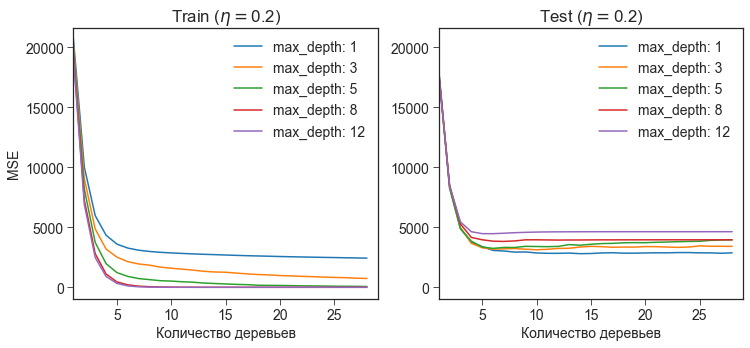

In [12]:
n_trees = np.array(range(1, 30))
max_depth = np.array([1, 3, 5, 8, 12])
eta = 0.2

errs_train = []
errs_test = []
labels = []

for depth in max_depth:
    labels.append(f'max_depth: {depth}')
    mse_train = []
    mse_test = []
    for n in n_trees:
        coefs = [1] * n
        trees, error_train, error_test = gb_fit(n, depth, X_train, X_test, y_train, y_test, coefs, eta)
        #train_mse, test_mse = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
        mse_train.append(error_train[-1])
        mse_test.append(error_test[-1])
    errs_train.append(mse_train)
    errs_test.append(mse_test)

get_error_plot(n, errs_train, errs_test, labels, eta)

Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций и глубины деревьев при $\eta=0.3$.

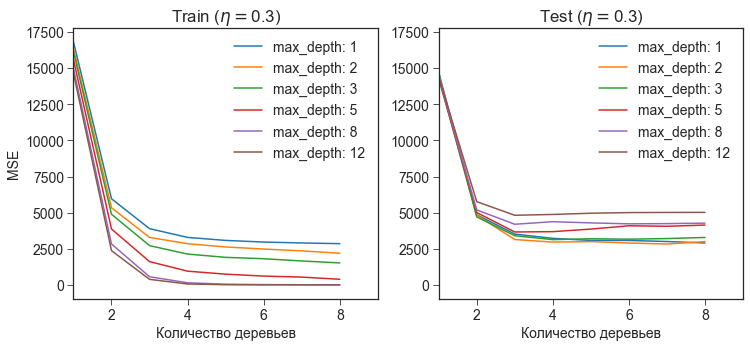

In [13]:
n_trees = np.array(range(1, 10))
max_depth = np.array([1, 2, 3, 5, 8, 12])
eta = 0.3

errs_train = []
errs_test = []
labels = []

for depth in max_depth:
    labels.append(f'max_depth: {depth}')
    mse_train = []
    mse_test = []
    for n in n_trees:
        coefs = [1] * n
        trees, error_train, error_test = gb_fit(n, depth, X_train, X_test, y_train, y_test, coefs, eta)
        #error_train, error_test = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
        mse_train.append(error_train[-1])
        mse_test.append(error_test[-1])
    errs_train.append(mse_train)
    errs_test.append(mse_test)

get_error_plot(n, errs_train, errs_test, labels, eta)

Результаты графического анализа (на тестовой выборке) свидетельствуют о том, что при $\eta=0.3$ наилучший результат даст комбинация небольшой глубины деревьев max_depth = 2 или 3, и количества деревьев n_trees = 3:
* Оранжевая и зеленая линии графиков.